In [1]:


import os, sys, time, copy, pickle as pkl
import numpy as np
import pandas as pd
import torch

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.titlesize'] = 18

In [2]:
from socket import gethostname
if 'devfair' in gethostname():
    output_dir = '/checkpoint/pillutla/pfl/outputs'
    output_dir_fed = '/checkpoint/pillutla/pfl/outputs_fed'
else:
    output_dir = '/Users/pillutla/Dropbox (Facebook)/code/pfl_outputs/outputs'
    output_dir_fed = '/Users/pillutla/Dropbox (Facebook)/code/pfl_outputs/outputs_fed'

In [3]:
def load_pkl(fn):
    if not os.path.isfile(fn):
        return None
    with open(fn, 'rb') as f:
        x = pkl.load(f)
    return x

# SO Personalized 1

In [6]:
param_list = [
    "tr_layer_0", "tr_layer_1", "tr_layer_0+1",
    *[f"adapter_{dim}" for dim in [2, 16, 128]]   
]

descr = "StackOverflow / Arch: Tiny"

# pfl_algo = "pfl_joint"
pfl_algo = "pfl_alternating"

fn = "so_tiny_{}_{}_{}.csv"

df_tr = []
df_te = []
for param in param_list:
    mode = "train"
    fn1 = fn.format(param, pfl_algo, mode)
    df_tr.append(pd.read_csv(os.path.join(output_dir_fed, fn1), index_col=0))
    df_tr[-1].columns.name = param
    mode = "test"
    fn1 = fn.format(param, pfl_algo, mode)
    df_te.append(pd.read_csv(os.path.join(output_dir_fed, fn1), index_col=0))
    df_te[-1].columns.name = param

# centralized
param = 'centralized'
fn = "so_tiny_lr10_seed1_{}.csv"
df1 = pd.read_csv(os.path.join(output_dir_fed, fn.format('train')), index_col=0)
df1.columns.name = param
df2 = pd.read_csv(os.path.join(output_dir_fed, fn.format('test')), index_col=0)
df2.columns.name = param

param_list.insert(0, param)
df_tr.insert(0, df1)
df_te.insert(0, df2)

print(df2['accuracy|mean'][-5:])


17    0.230714
18    0.231091
19    0.234499
20    0.235110
21    0.235110
Name: accuracy|mean, dtype: float64


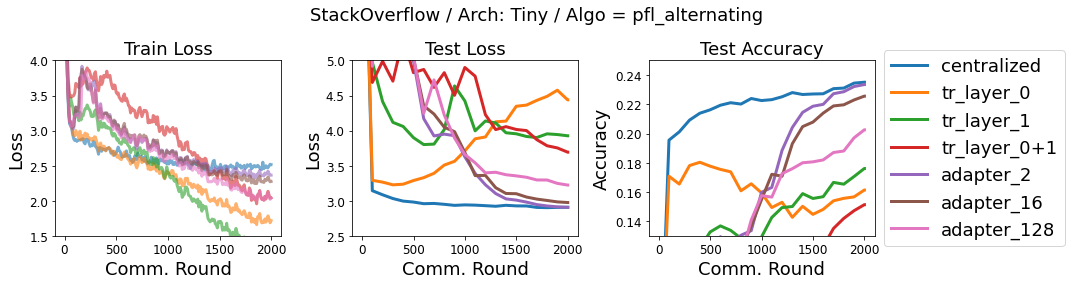

In [5]:
f, ax = plt.subplots(1, 3, figsize=(15, 4))
f.suptitle(f'{descr} / Algo = {pfl_algo}', fontsize=18)

for i, (p, df) in enumerate(zip(param_list, df_tr)):
    ax[0].plot(df['round'], df['avg_loss'], alpha=0.6, label=p)

for param, df in zip(param_list, df_te):
    ax[1].plot(df['round'], df['loss|mean'], label=param)
    ax[2].plot(df['round'], df['accuracy|mean'], label=param)

ax[0].set_title('Train Loss', fontsize=18)
ax[1].set_title('Test Loss', fontsize=18)
ax[2].set_title("Test Accuracy", fontsize=18)
for a in ax:
    a.set_xlabel('Comm. Round', fontsize=18)
    a.set_ylabel('Loss', fontsize=18)   
ax[2].set_ylabel("Accuracy", fontsize=18)

# ax[0].legend(fontsize=18)
ax[0].set_ylim((1.5, 4))
ax[1].set_ylim((2.5, 5))
ax[2].set_ylim((0.13, 0.25))

ax[-1].legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, fontsize=18)

plt.tight_layout()

# EMNIST

In [36]:
param_list = ['inp_layer', 'out_layer', 'adapter', 'res_layer_1+2']

pretrained = True
if pretrained:
    descr = "EMNIST / ResNet-18 / Pretrained"
    fn = "emnist_resnetgn_{}_{}_pretrained_{}.csv"
else:
    descr = "EMNIST / ResNet-18"
    fn = "emnist_resnetgn_{}_{}_{}.csv"

# pfl_algo = "pfl_joint"
pfl_algo = "pfl_alternating"


df_tr = []
df_te = []
for param in param_list:
    mode = "train"
    fn1 = fn.format(param, pfl_algo, mode)
    df_tr.append(pd.read_csv(os.path.join(output_dir_fed, fn1), index_col=0))
    df_tr[-1].columns.name = param
    mode = "test"
    fn1 = fn.format(param, pfl_algo, mode)
    df_te.append(pd.read_csv(os.path.join(output_dir_fed, fn1), index_col=0))
    df_te[-1].columns.name = param

# centralized
param = 'centralized'
fn = "emnist_resnetgn_s-sgd_lr0.5_lre500_{}.csv"
df1 = pd.read_csv(os.path.join(output_dir_fed, fn.format('train')), index_col=0)
df1.columns.name = param
df2 = pd.read_csv(os.path.join(output_dir_fed, fn.format('test')), index_col=0)
df2.columns.name = param

param_list.insert(0, param)
df_tr.insert(0, df1)
df_te.insert(0, df2)


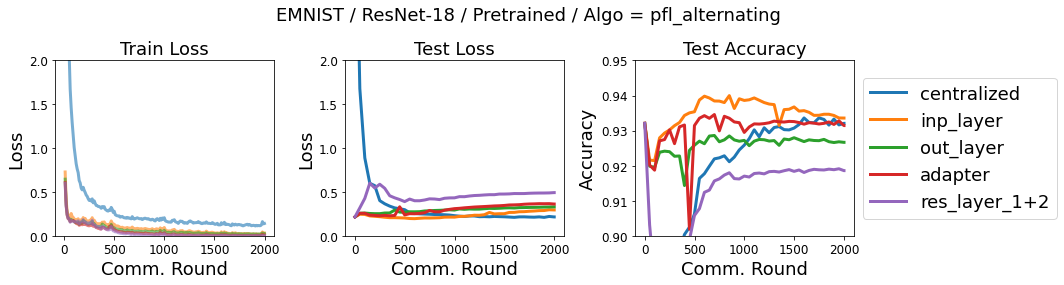

In [37]:
f, ax = plt.subplots(1, 3, figsize=(15, 4))
f.suptitle(f'{descr} / Algo = {pfl_algo}', fontsize=18)

for i, (p, df) in enumerate(zip(param_list, df_tr)):
    ax[0].plot(df['round'], df['avg_loss'], alpha=0.6, label=p)

for param, df in zip(param_list, df_te):
    ax[1].plot(df['round'], df['loss|mean'], label=param)
    ax[2].plot(df['round'], df['accuracy|mean'], label=param)

ax[0].set_title('Train Loss', fontsize=18)
ax[1].set_title('Test Loss', fontsize=18)
ax[2].set_title("Test Accuracy", fontsize=18)
for a in ax:
    a.set_xlabel('Comm. Round', fontsize=18)
    a.set_ylabel('Loss', fontsize=18)   
ax[2].set_ylabel("Accuracy", fontsize=18)

ax[0].set_ylim((0, 2))
ax[1].set_ylim((0, 2))
ax[2].set_ylim((0.9, 0.95))

ax[-1].legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, fontsize=18)

plt.tight_layout()